In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



Using TensorFlow backend.


In [3]:
import random
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scripts.data_generator as data_generator
import scripts.feature_ranking as feature_ranking
import scripts.features_2d as features_2d
import scripts.ga as ga
import scripts.ga_evaluation as ga_evaluation
import tensorflow as tf
from IPython import get_ipython

from tqdm import tqdm
import seaborn as sns

from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
plt.ion()
plt.show()


random_state=4
random.seed( random_state )
np.random.seed(random_state)
method = "adapted_ratkowsky_lance"#"point_biserial"#"PBM_index"#"silhouette"#

/usr/local/lib/python3.6/dist-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [4]:
%load_ext autoreload
%autoreload 2

In [13]:
for t in range(5):
    print(f"\n T = {t}")
    n_clusters_per_subpace = [4,4]
    random.seed(t)
    np.random.seed(t)
    cluster_std = 0.17
    n_redundant_clusters = 1
    n_redundant_cluster_size = 1
    data, best_subspaces, truths = data_generator.make_data_for_ga(
                         n_clusters_per_subpace,
                         cluster_std=[cluster_std] * len(n_clusters_per_subpace),
                         n_uniform_features=300,
                         n_normal_features=300,
                         n_neg_binomial=100,
                         n_gamma=0,
                         n_beta=0,
                         random_redundant=True,
                         n_redundant=2,
                         n_outlier_features=0,
                         n_cutoff=0,
                         n_bimodal_features=0,
                         min_subspace_features=15,
                         max_subspace_features=20,
                         max_neg_bin_p = 0.3,
                         n_samples=200,
                         plot=False)


    z_file = None
    truth = None
    n_clusters = 4


    meta_features = feature_ranking.rank_features(data,
                                                  nb_bins=20,
                                                  rank_threshold=90,
                                                  z_file=z_file,
                                                  metric='correlation',
                                                  redundant_threshold=0.4)
    
    clustering ="gmm"#"KMeans"#"MeanShift"

    meta_features = feature_ranking.rank_features(data,
                                                  nb_bins=20,
                                                  rank_threshold=90,
                                                  z_file=None,
                                                  metric='euclidean',
                                                  redundant_threshold=0.4)

    model_file = f'models/gmm_arl.h5'  # f'models/cnn.h5'  # f'models/model2d_conv1d.h5' #
#     population, n = features_2d.run(
#         data,
#         n_clusters,
#         meta_features,
#         model_file=model_file,
#         add_close_population=False,
#         theta=0.09,
#     )
#     population = population.iloc[:500]
    population = None

    globalResults = {}
    round_size = 4
    epochs = 2*round_size
    debug = False
    ignore_redundant= True

#     model_file =   f'models/nn.h5'  # f'models/model2d_conv1d.h5' #
#     population, n = features_2d.run(data,
#                            meta_features,
#                            model_file=model_file,
#                            add_close_population=False)

#     archive2D = ga.cluster_population(population,
#                                       data,
#                                       n_clusters,
#                                       method,
#                                       truth=None,
#                                       threshold=0.09)


    sampling = {
        "ARCHIVE2D": { 
            "ga": 0,
            "max": 0},
        "CLOSE": { 
            "ga": 0.33,
            "max": 0.33 },
        "IMP1D": { 
            "ga": 0.33,
            "max": 0.33 },
        "RANDOM": { 
            "ga": 0.34,
            "max": 0.34},
    }
    params = ga.ga_parameters(
        n_clusters,
        data.shape[1],
        truth,
        meta_features,
        method=method,
        truth_methods=['ari'],
        archive_2d=population,
        debug=debug,
        epochs=epochs,
        round_size=round_size,
        sampling = sampling,
        ignore_redundant = ignore_redundant,
        allow_subspace_overlap = True,
        improvement_per_mutation_report = True,
        score_tolerance=0.009,
        clustering = clustering

    )
    print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])

    solutions, archive= ga.run(data, params)

    globalResults["all_equal"] = solutions

    sampling = {
        "ARCHIVE2D": { 
            "ga": 0.0,
            "max": 0.0 },
        "CLOSE": { 
            "ga": 0,
            "max": 0 },
        "IMP1D": { 
            "ga": 0.5,
            "max": 0.5 },
        "RANDOM": { 
            "ga": 0.5,
            "max": 0.5},
    }
    params = ga.ga_parameters(
        n_clusters,
        data.shape[1],
        truth,
        meta_features,
        method=method,
        truth_methods=['ari'],
        archive_2d=population,
        debug=debug,
        epochs=epochs,
        round_size=round_size,
        sampling = sampling,
        ignore_redundant = ignore_redundant,
        allow_subspace_overlap = True,
        improvement_per_mutation_report = True,
        score_tolerance=0.009,
        clustering = clustering

    )
    print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])

    solutions, archive= ga.run(data, params)
    globalResults["no_close"] = solutions

    sampling = {
        "ARCHIVE2D": { 
            "ga": 0,
            "max": 0},
        "CLOSE": { 
            "ga": 0.5,
            "max": 0.5},
        "IMP1D": { 
            "ga": 0,
            "max": 0 },
        "RANDOM": { 
            "ga": 0.5,
            "max": 0.5},
    }
    params = ga.ga_parameters(
        n_clusters,
        data.shape[1],
        truth,
        meta_features,
        method=method,
        truth_methods=['ari'],
        archive_2d=population,
        debug=debug,
        epochs=epochs,
        round_size=round_size,
        sampling = sampling,
        ignore_redundant = ignore_redundant,
        allow_subspace_overlap = True,
        improvement_per_mutation_report = True,
        score_tolerance=0.009,
        clustering = clustering

    )
    print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])

    solutions, archive= ga.run(data, params)
    globalResults["no_imp"] = solutions

    #######################
    sampling = {
        "ARCHIVE2D": { 
            "ga": 0,
            "max": 0},
        "CLOSE": { 
            "ga": 0,
            "max": 0},
        "IMP1D": { 
            "ga": 1,
            "max": 1 },
        "RANDOM": { 
            "ga": 0,
            "max": 0},
    }
    params = ga.ga_parameters(
        n_clusters,
        data.shape[1],
        truth,
        meta_features,
        method=method,
        truth_methods=['ari'],
        archive_2d=population,
        debug=debug,
        epochs=epochs,
        round_size=round_size,
        sampling = sampling,
        ignore_redundant = ignore_redundant,
        allow_subspace_overlap = True,
        improvement_per_mutation_report = True,
        score_tolerance=0.009,
        clustering = clustering

    )
    print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])

    solutions, archive= ga.run(data, params)
    globalResults["imp"] = solutions
    
    ################################
    sampling = {
        "ARCHIVE2D": { 
            "ga": 0,
            "max": 0},
        "CLOSE": { 
            "ga": 1,
            "max": 1},
        "IMP1D": { 
            "ga": 0,
            "max": 0 },
        "RANDOM": { 
            "ga": 0,
            "max": 0},
    }
    params = ga.ga_parameters(
        n_clusters,
        data.shape[1],
        truth,
        meta_features,
        method=method,
        truth_methods=['ari'],
        archive_2d=population,
        debug=debug,
        epochs=epochs,
        round_size=round_size,
        sampling = sampling,
        ignore_redundant = ignore_redundant,
        allow_subspace_overlap = True,
        improvement_per_mutation_report = True,
        score_tolerance=0.009,
        clustering = clustering

    )
    print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])

    solutions, archive= ga.run(data, params)
    globalResults["close"] = solutions
    ############################################
    sampling = {
        "ARCHIVE2D": { 
            "ga": 0,
            "max": 0},
        "CLOSE": { 
            "ga": 0,
            "max": 0},
        "IMP1D": { 
            "ga": 0,
            "max": 0 },
        "RANDOM": { 
            "ga": 1,
            "max": 1},
    }
    params = ga.ga_parameters(
        n_clusters,
        data.shape[1],
        truth,
        meta_features,
        method=method,
        truth_methods=['ari'],
        archive_2d=population,
        debug=debug,
        epochs=epochs,
        round_size=round_size,
        sampling = sampling,
        ignore_redundant = ignore_redundant,
        allow_subspace_overlap = True,
        improvement_per_mutation_report = True,
        score_tolerance=0.009,
        clustering = clustering

    )
    print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])

    solutions, archive= ga.run(data, params)
    globalResults["random"] = solutions
    
    
    sampling = {
        "ARCHIVE2D": { 
            "ga": 0,
            "max": 0 },
        "CLOSE": { 
            "ga": 0.5,
            "max": 0.5 },
        "IMP1D": { 
            "ga": 0.5,
            "max": 0.5 },
        "RANDOM": { 
            "ga": 0,
            "max": 0},
    }
    params = ga.ga_parameters(
        n_clusters,
        data.shape[1],
        truth,
        meta_features,
        method=method,
        truth_methods=['ari'],
        archive_2d=population,
        debug=debug,
        epochs=epochs,
        round_size=round_size,
        sampling = sampling,
        ignore_redundant = ignore_redundant,
        allow_subspace_overlap = True,
        improvement_per_mutation_report = True,
        score_tolerance=0.009,
        clustering = clustering

    )
    print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])

    solutions, archive= ga.run(data, params)
    globalResults["no_random"] = solutions



    keys = list(globalResults.keys())
    columns = ["experiment", "subspace_id", "identified_features", "extra_features", 
               "subspace", "missed_features", "ari"]
    eval_df = pd.DataFrame(columns = columns)
    for experiment in keys:
        df = globalResults[experiment]
        features = df['features'].values
        predicted_partitions = df['partition'].values
        for sid, subspace in enumerate(best_subspaces):
            subspace_df = pd.DataFrame(columns = columns)
            for i in range(len(features)):
                cur_subspace = features[i]
                identified_features = len(np.intersect1d(cur_subspace, subspace))/len(subspace)
                extra_features = len(np.setdiff1d(cur_subspace, subspace))
                missed_features = np.setdiff1d(subspace, cur_subspace)
                ari = adjusted_rand_score(truths[sid], predicted_partitions[i])
                subspace_df.loc[subspace_df.shape[0]] = [experiment, sid, identified_features, 
                                                         extra_features, subspace, missed_features, ari]
            subspace_df = subspace_df[subspace_df["identified_features"]== subspace_df["identified_features"].max()]
            if subspace_df["identified_features"].max() ==0:
                subspace_df = subspace_df.iloc[:1]
            eval_df = pd.concat([eval_df, subspace_df], ignore_index=True, sort = False)



#     final_result = eval_df.groupby(["subspace_id", "experiment"]).agg({"identified_features": max}
#                                                                      ).unstack("experiment")
    eval_df.to_pickle(f"../data/sampling_results_{t}.pkl")
    display(eval_df)



 T = 0
Total: (200, 736), uniform (200, 300) , normal (200, 300),neg bin (200, 100), gamma (200, 0), moon (200, 2), circle (200, 2),  bimodal (200, 0), redundat (200, 2), outliers with uniform (200, 0), outliers with normal (200, 0) ,outlier binomial (200, 0), beta features (200, 0), 
*** Computing 1D feature ranking ...
Dispersion tests took 0.01 sec
Entropy computation 0.2 sec
KNN computation 0.06 sec
Sorting and thresholds 0.01 sec
Performing hierarchical clustering...
Hierarchical clustering 0.03 sec
Handle redundant features 0.01 sec
Returning 2 redundant features and  16 important features
*** Computing 1D feature ranking ...
Dispersion tests took 0.01 sec


  0%|          | 0/9 [00:00<?, ?it/s]

Entropy computation 0.21 sec
KNN computation 0.01 sec
Sorting and thresholds 0.02 sec
Performing hierarchical clustering...
Hierarchical clustering 0.05 sec
Handle redundant features 0.01 sec
Returning 0 redundant features and  16 important features
*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 16
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 33 33 34] [0, 0.33, 0.33, 0.34]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.98s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.17,"[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...","[3, 3, 3, 1, 0, 1, 0, 2, 3, 2, 3, 3, 2, 3, 2, ...",0.31,0.43,16.0,"Counter({3: 50, 1: 50, 0: 50, 2: 50})"


adding 15 random population


 89%|████████▉ | 8/9 [00:45<00:05,  5.34s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.17,"[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...","[3, 3, 3, 1, 0, 1, 0, 2, 3, 2, 3, 3, 2, 3, 2, ...",0.31,0.43,16.0,"Counter({3: 50, 1: 50, 0: 50, 2: 50})"
1,0.16,"[19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 33]","[1, 3, 2, 0, 1, 3, 1, 1, 2, 2, 2, 1, 0, 3, 1, ...",0.25,0.42,11.0,"Counter({1: 50, 3: 50, 2: 50, 0: 50})"


adding 11 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 16
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0  0 50 50] [0.0, 0, 0.5, 0.5]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:20,  4.13s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14,...","[2, 2, 2, 3, 0, 3, 0, 1, 2, 1, 2, 2, 1, 2, 1, ...",0.33,0.45,18.0,"Counter({2: 50, 3: 50, 0: 50, 1: 50})"


adding 15 random population


 89%|████████▉ | 8/9 [00:55<00:06,  6.40s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14,...","[2, 2, 2, 3, 0, 3, 0, 1, 2, 1, 2, 2, 1, 2, 1, ...",0.33,0.45,18.0,"Counter({2: 50, 3: 50, 0: 50, 1: 50})"
1,0.13,"[88, 112]","[3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 2, 0, 3, 2, ...",0.17,0.45,2.0,"Counter({2: 56, 3: 49, 0: 48, 1: 47})"


adding 2 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 16
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 50  0 50] [0, 0.5, 0, 0.5]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:20,  4.04s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[97, 279, 734]","[3, 0, 3, 2, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, ...",0.17,0.38,3.0,"Counter({0: 60, 1: 57, 2: 55, 3: 28})"


adding 3 random population


 89%|████████▉ | 8/9 [00:36<00:04,  4.38s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[97, 279, 734]","[3, 0, 3, 2, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, ...",0.17,0.38,3.0,"Counter({0: 60, 1: 57, 2: 55, 3: 28})"
1,0.16,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 17...","[2, 2, 2, 3, 0, 3, 0, 1, 2, 1, 2, 2, 1, 2, 1, ...",0.27,0.38,15.0,"Counter({2: 50, 3: 50, 0: 50, 1: 50})"


adding 17 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 16
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0   0 100   0] [0, 0, 1, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:19,  3.86s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.17,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 2, 2, 3, 0, 3, 0, 1, 2, 1, 2, 2, 1, 2, 1, ...",0.33,0.45,18.0,"Counter({2: 50, 3: 50, 0: 50, 1: 50})"


adding 20 random population


 89%|████████▉ | 8/9 [00:55<00:06,  6.46s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.17,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 2, 2, 3, 0, 3, 0, 1, 2, 1, 2, 2, 1, 2, 1, ...",0.33,0.45,18.0,"Counter({2: 50, 3: 50, 0: 50, 1: 50})"
1,0.13,"[67, 127]","[1, 1, 3, 2, 3, 1, 0, 1, 3, 0, 1, 2, 1, 1, 0, ...",0.17,0.43,2.0,"Counter({1: 59, 0: 53, 2: 51, 3: 37})"


adding 1 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 16
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0 100   0   0] [0, 1, 0, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.92s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[0, 1, 2, 4, 5, 6, 8, 10, 12, 13, 17, 18]","[1, 1, 1, 3, 0, 3, 0, 2, 1, 2, 1, 1, 2, 1, 2, ...",0.26,0.4,12.0,"Counter({1: 50, 3: 50, 0: 50, 2: 50})"


adding 11 random population


 89%|████████▉ | 8/9 [00:44<00:05,  5.04s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[0, 1, 2, 4, 5, 6, 8, 10, 12, 13, 17, 18]","[1, 1, 1, 3, 0, 3, 0, 2, 1, 2, 1, 1, 2, 1, 2, ...",0.26,0.40,12.0,"Counter({1: 50, 3: 50, 0: 50, 2: 50})"
1,0.16,"[19, 21, 24, 25, 27, 28, 29, 33]","[1, 3, 2, 0, 1, 3, 1, 1, 2, 2, 2, 1, 0, 3, 1, ...",0.23,0.46,8.0,"Counter({1: 50, 3: 50, 2: 50, 0: 50})"


adding 19 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 16
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0   0   0 100] [0, 0, 0, 1]
RANDOM!!
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:19,  3.84s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[55, 64]","[0, 2, 0, 2, 1, 0, 0, 0, 3, 0, 3, 1, 3, 2, 2, ...",0.15,0.41,2.0,"Counter({0: 63, 2: 49, 3: 45, 1: 43})"


RANDOM!!
adding 2 random population


 89%|████████▉ | 8/9 [00:35<00:04,  4.34s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[55, 64]","[0, 2, 0, 2, 1, 0, 0, 0, 3, 0, 3, 1, 3, 2, 2, ...",0.15,0.41,2.0,"Counter({0: 63, 2: 49, 3: 45, 1: 43})"
1,0.13,"[181, 195]","[1, 1, 3, 2, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 0, ...",0.16,0.43,2.0,"Counter({3: 58, 1: 53, 2: 51, 0: 38})"


RANDOM!!
adding 3 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 16
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 50 50  0] [0, 0.5, 0.5, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:20,  4.00s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.17,"[0, 1, 2, 4, 5, 6, 8, 9, 11, 12, 14, 15, 16, 18]","[3, 3, 3, 2, 0, 2, 0, 1, 3, 1, 3, 3, 1, 3, 1, ...",0.29,0.44,14.0,"Counter({3: 50, 2: 50, 0: 50, 1: 50})"


adding 10 random population


 89%|████████▉ | 8/9 [00:50<00:05,  5.84s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.17,"[0, 1, 2, 4, 5, 6, 8, 9, 11, 12, 14, 15, 16, 18]","[3, 3, 3, 2, 0, 2, 0, 1, 3, 1, 3, 3, 1, 3, 1, ...",0.29,0.44,14.0,"Counter({3: 50, 2: 50, 0: 50, 1: 50})"
1,0.16,"[19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 33]","[1, 3, 2, 0, 1, 3, 1, 1, 2, 2, 2, 1, 0, 3, 1, ...",0.25,0.42,11.0,"Counter({1: 50, 3: 50, 2: 50, 0: 50})"


adding 12 random population


100%|██████████| 9/9 [01:03<00:00,  7.03s/it]


,experiment,subspace_id,identified_features,extra_features,subspace,missed_features,ari
0,all_equal,0,0.842105,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3, 7, 18]",1.000000
1,all_equal,1,0.733333,0,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...","[23, 30, 31, 32]",1.000000
2,no_close,0,0.947368,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[10],1.000000
3,no_close,1,0.000000,18,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...","[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...",-0.010433
4,no_imp,0,0.789474,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[7, 14, 15, 16]",1.000000
5,no_imp,1,0.000000,3,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...","[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...",-0.003321
6,imp,0,0.947368,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[4],1.000000
7,imp,1,0.000000,18,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...","[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...",-0.010433
8,close,0,0.631579,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3, 7, 9, 11, 14, 15, 16]",1.000000
9,close,1,0.533333,0,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...","[20, 22, 23, 26, 30, 31, 32]",1.000000



 T = 1
Total: (200, 739), uniform (200, 300) , normal (200, 300),neg bin (200, 100), gamma (200, 0), moon (200, 2), circle (200, 2),  bimodal (200, 0), redundat (200, 2), outliers with uniform (200, 0), outliers with normal (200, 0) ,outlier binomial (200, 0), beta features (200, 0), 
*** Computing 1D feature ranking ...
Dispersion tests took 0.02 sec
Entropy computation 0.22 sec
KNN computation 0.06 sec
Sorting and thresholds 0.01 sec
Performing hierarchical clustering...
Hierarchical clustering 0.03 sec
Handle redundant features 0.01 sec
Returning 3 redundant features and  10 important features
*** Computing 1D feature ranking ...
Dispersion tests took 0.01 sec


  0%|          | 0/9 [00:00<?, ?it/s]

Entropy computation 0.22 sec
KNN computation 0.01 sec
Sorting and thresholds 0.02 sec
Performing hierarchical clustering...
Hierarchical clustering 0.07 sec
Handle redundant features 0.01 sec
Returning 0 redundant features and  10 important features
*** Optimization algorithm 
Non redundant features 739, orig size 739, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 33 33 34] [0, 0.33, 0.33, 0.34]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:20,  4.02s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[136, 215]","[2, 0, 3, 2, 1, 1, 0, 3, 0, 2, 3, 2, 0, 1, 1, ...",0.16,0.42,2.0,"Counter({0: 58, 1: 58, 3: 44, 2: 40})"


adding 3 random population


 89%|████████▉ | 8/9 [00:34<00:04,  4.23s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[136, 215]","[2, 0, 3, 2, 1, 1, 0, 3, 0, 2, 3, 2, 0, 1, 1, ...",0.16,0.42,2.0,"Counter({0: 58, 1: 58, 3: 44, 2: 40})"
1,0.16,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 2, 0, 3, 1, 3, 1, 2, 1, 2, 2, 3, 2, 0, 0, ...",0.30,0.38,18.0,"Counter({2: 50, 0: 50, 3: 50, 1: 50})"


adding 20 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 739, orig size 739, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0  0 50 50] [0.0, 0, 0.5, 0.5]
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:18,  3.74s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[3, 3, 0, 2, 1, 2, 1, 3, 1, 3, 3, 2, 3, 0, 0, ...",0.31,0.4,18.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"


adding 10 random population


 89%|████████▉ | 8/9 [00:46<00:05,  5.46s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[3, 3, 0, 2, 1, 2, 1, 3, 1, 3, 3, 2, 3, 0, 0, ...",0.31,0.40,18.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"
1,0.13,"[132, 183]","[3, 3, 3, 3, 1, 1, 2, 3, 0, 0, 0, 1, 0, 0, 2, ...",0.16,0.44,2.0,"Counter({3: 57, 1: 57, 0: 44, 2: 42})"


adding 2 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 739, orig size 739, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 50  0 50] [0, 0.5, 0, 0.5]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.93s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[0, 1, 2, 3, 5, 7, 8, 10, 11, 12, 13, 14, 15, ...","[3, 3, 0, 2, 1, 2, 1, 3, 1, 3, 3, 2, 3, 0, 0, ...",0.28,0.38,16.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"


adding 7 random population


 89%|████████▉ | 8/9 [00:42<00:05,  5.16s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[0, 1, 2, 3, 5, 7, 8, 10, 11, 12, 13, 14, 15, ...","[3, 3, 0, 2, 1, 2, 1, 3, 1, 3, 3, 2, 3, 0, 0, ...",0.28,0.38,16.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"
1,0.16,"[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3...","[2, 0, 3, 0, 2, 2, 1, 0, 0, 2, 0, 1, 1, 3, 2, ...",0.27,0.42,16.0,"Counter({2: 50, 0: 50, 3: 50, 1: 50})"


adding 15 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 739, orig size 739, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0   0 100   0] [0, 0, 1, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:18,  3.72s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[18, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 3...","[2, 0, 3, 0, 2, 2, 1, 0, 0, 2, 0, 1, 1, 3, 2, ...",0.26,0.37,18.0,"Counter({2: 50, 0: 50, 3: 50, 1: 50})"


adding 18 random population


 89%|████████▉ | 8/9 [00:52<00:05,  5.97s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[18, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 3...","[2, 0, 3, 0, 2, 2, 1, 0, 0, 2, 0, 1, 1, 3, 2, ...",0.26,0.37,18.0,"Counter({2: 50, 0: 50, 3: 50, 1: 50})"
1,0.17,"[6, 8, 9, 10, 13, 16]","[3, 3, 0, 2, 1, 2, 1, 3, 1, 3, 3, 2, 3, 0, 0, ...",0.24,0.50,6.0,"Counter({2: 53, 3: 50, 1: 50, 0: 47})"


adding 18 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 739, orig size 739, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0 100   0   0] [0, 1, 0, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.87s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[0, 1, 3, 5, 7, 9, 10, 11, 12, 13, 17]","[3, 3, 0, 2, 1, 2, 1, 3, 1, 3, 3, 2, 3, 0, 0, ...",0.24,0.37,11.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"


adding 9 random population


 89%|████████▉ | 8/9 [00:46<00:05,  5.33s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[0, 1, 3, 5, 7, 9, 10, 11, 12, 13, 17]","[3, 3, 0, 2, 1, 2, 1, 3, 1, 3, 3, 2, 3, 0, 0, ...",0.24,0.37,11.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"
1,0.15,"[18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...","[2, 0, 3, 0, 2, 2, 1, 0, 0, 2, 0, 1, 1, 3, 2, ...",0.27,0.38,19.0,"Counter({2: 50, 0: 50, 3: 50, 1: 50})"


adding 11 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 739, orig size 739, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0   0   0 100] [0, 0, 0, 1]
RANDOM!!
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:19,  3.82s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[1, 16, 253]","[1, 1, 0, 0, 1, 2, 1, 3, 1, 3, 3, 2, 3, 0, 2, ...",0.18,0.46,3.0,"Counter({2: 54, 1: 53, 0: 47, 3: 46})"


RANDOM!!
adding 2 random population


 89%|████████▉ | 8/9 [00:34<00:04,  4.08s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[1, 16, 253]","[1, 1, 0, 0, 1, 2, 1, 3, 1, 3, 3, 2, 3, 0, 2, ...",0.18,0.46,3.0,"Counter({2: 54, 1: 53, 0: 47, 3: 46})"
1,0.13,"[175, 215]","[1, 0, 1, 1, 0, 0, 2, 1, 0, 1, 3, 3, 2, 2, 0, ...",0.16,0.43,2.0,"Counter({2: 60, 0: 58, 3: 47, 1: 35})"


RANDOM!!
adding 2 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 739, orig size 739, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 50 50  0] [0, 0.5, 0.5, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:19,  3.84s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3...","[2, 0, 3, 0, 2, 2, 1, 0, 0, 2, 0, 1, 1, 3, 2, ...",0.27,0.41,17.0,"Counter({2: 50, 0: 50, 3: 50, 1: 50})"


adding 22 random population


 89%|████████▉ | 8/9 [00:46<00:05,  5.45s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3...","[2, 0, 3, 0, 2, 2, 1, 0, 0, 2, 0, 1, 1, 3, 2, ...",0.27,0.41,17.0,"Counter({2: 50, 0: 50, 3: 50, 1: 50})"
1,0.13,"[14, 16, 245]","[1, 3, 2, 2, 1, 0, 3, 3, 3, 3, 3, 2, 1, 2, 2, ...",0.18,0.45,3.0,"Counter({2: 62, 3: 54, 1: 46, 0: 38})"


adding 13 random population


100%|██████████| 9/9 [00:53<00:00,  5.95s/it]


,experiment,subspace_id,identified_features,extra_features,subspace,missed_features,ari
0,all_equal,0,0.944444,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[4],1.000000
1,all_equal,1,0.000000,2,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...","[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...",-0.001888
2,no_close,0,0.944444,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[4],1.000000
3,no_close,1,0.052632,17,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...","[18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...",0.012581
4,no_imp,0,0.833333,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[4, 6, 9]",1.000000
5,no_imp,1,0.842105,0,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...","[18, 19, 33]",1.000000
6,imp,0,0.333333,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 7, 11, 12, 14, 15, 17]",0.960630
7,imp,1,0.894737,1,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...","[19, 27]",1.000000
8,close,0,0.611111,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2, 4, 6, 8, 14, 15, 16]",1.000000
9,close,1,0.947368,1,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2...",[19],1.000000



 T = 2
Total: (200, 736), uniform (200, 300) , normal (200, 300),neg bin (200, 100), gamma (200, 0), moon (200, 2), circle (200, 2),  bimodal (200, 0), redundat (200, 2), outliers with uniform (200, 0), outliers with normal (200, 0) ,outlier binomial (200, 0), beta features (200, 0), 
*** Computing 1D feature ranking ...
Dispersion tests took 0.01 sec
Entropy computation 0.21 sec
KNN computation 0.05 sec
Sorting and thresholds 0.01 sec
Performing hierarchical clustering...
Hierarchical clustering 0.03 sec
Handle redundant features 0.01 sec
Returning 1 redundant features and  10 important features
*** Computing 1D feature ranking ...
Dispersion tests took 0.01 sec


  0%|          | 0/9 [00:00<?, ?it/s]

Entropy computation 0.21 sec
KNN computation 0.01 sec
Sorting and thresholds 0.01 sec
Performing hierarchical clustering...
Hierarchical clustering 0.03 sec
Handle redundant features 0.0 sec
Returning 0 redundant features and  10 important features
*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 33 33 34] [0, 0.33, 0.33, 0.34]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:20,  4.07s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[15, 17, 18, 19, 20, 21, 22, 25, 26, 31, 32, 33]","[1, 1, 3, 2, 3, 3, 3, 0, 2, 1, 1, 0, 3, 0, 1, ...",0.24,0.44,12.0,"Counter({1: 50, 3: 50, 2: 50, 0: 50})"


adding 14 random population


 89%|████████▉ | 8/9 [00:46<00:05,  5.50s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[15, 17, 18, 19, 20, 21, 22, 25, 26, 31, 32, 33]","[1, 1, 3, 2, 3, 3, 3, 0, 2, 1, 1, 0, 3, 0, 1, ...",0.24,0.44,12.0,"Counter({1: 50, 3: 50, 2: 50, 0: 50})"
1,0.16,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3, 1, 0, 0, 3, 0, 1, 1, 3, 3, 0, 2, 3, 0, 0, ...",0.27,0.42,15.0,"Counter({3: 50, 1: 50, 0: 50, 2: 50})"


adding 11 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0  0 50 50] [0.0, 0, 0.5, 0.5]
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:18,  3.75s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[18, 19, 20, 21, 22, 23, 27, 28, 29, 30, 32, 33]","[2, 2, 3, 1, 3, 3, 3, 0, 1, 2, 2, 0, 3, 0, 2, ...",0.24,0.41,12.0,"Counter({2: 50, 3: 50, 1: 50, 0: 50})"


adding 11 random population


 89%|████████▉ | 8/9 [00:42<00:05,  5.06s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[18, 19, 20, 21, 22, 23, 27, 28, 29, 30, 32, 33]","[2, 2, 3, 1, 3, 3, 3, 0, 1, 2, 2, 0, 3, 0, 2, ...",0.24,0.41,12.0,"Counter({2: 50, 3: 50, 1: 50, 0: 50})"
1,0.15,"[1, 5, 8, 13, 14]","[3, 1, 0, 0, 3, 0, 1, 1, 3, 3, 0, 2, 3, 0, 0, ...",0.18,0.49,5.0,"Counter({3: 51, 1: 50, 0: 50, 2: 49})"


adding 15 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 50  0 50] [0, 0.5, 0, 0.5]
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:18,  3.78s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[17, 18, 19, 20, 21, 22, 23, 25, 29, 30, 32, 33]","[1, 1, 3, 2, 3, 3, 3, 0, 2, 1, 1, 0, 3, 0, 1, ...",0.25,0.42,12.0,"Counter({1: 50, 3: 50, 2: 50, 0: 50})"


adding 10 random population


 89%|████████▉ | 8/9 [00:42<00:05,  5.12s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[17, 18, 19, 20, 21, 22, 23, 25, 29, 30, 32, 33]","[1, 1, 3, 2, 3, 3, 3, 0, 2, 1, 1, 0, 3, 0, 1, ...",0.25,0.42,12.0,"Counter({1: 50, 3: 50, 2: 50, 0: 50})"
1,0.15,"[2, 3, 4, 5, 6, 8, 10, 12, 13, 14]","[3, 1, 0, 0, 3, 0, 1, 1, 3, 3, 0, 2, 3, 0, 0, ...",0.23,0.43,10.0,"Counter({3: 50, 1: 50, 0: 50, 2: 50})"


adding 5 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0   0 100   0] [0, 0, 1, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:18,  3.69s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[19, 20, 21, 22, 27, 32]","[1, 3, 3, 2, 3, 3, 3, 0, 2, 1, 1, 0, 0, 0, 1, ...",0.18,0.37,6.0,"Counter({0: 53, 1: 49, 3: 49, 2: 49})"


adding 8 random population


 89%|████████▉ | 8/9 [00:36<00:04,  4.20s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[19, 20, 21, 22, 27, 32]","[1, 3, 3, 2, 3, 3, 3, 0, 2, 1, 1, 0, 0, 0, 1, ...",0.18,0.37,6.0,"Counter({0: 53, 1: 49, 3: 49, 2: 49})"
1,0.15,"[1, 3, 5, 6, 7, 8, 11, 12]","[1, 2, 0, 0, 1, 0, 2, 2, 1, 1, 0, 3, 1, 0, 0, ...",0.19,0.30,8.0,"Counter({2: 58, 1: 50, 3: 49, 0: 43})"


adding 18 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0 100   0   0] [0, 1, 0, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.94s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2, 1, 0, 0, 2, 0, 1, 1, 2, 2, 0, 3, 2, 0, 0, ...",0.25,0.36,16.0,"Counter({2: 50, 1: 50, 0: 50, 3: 50})"


adding 8 random population


 89%|████████▉ | 8/9 [00:44<00:05,  5.23s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2, 1, 0, 0, 2, 0, 1, 1, 2, 2, 0, 3, 2, 0, 0, ...",0.25,0.36,16.0,"Counter({2: 50, 1: 50, 0: 50, 3: 50})"
1,0.16,"[17, 19, 20, 21, 25, 29, 32, 33]","[1, 1, 3, 2, 3, 3, 3, 0, 2, 1, 1, 0, 3, 0, 1, ...",0.20,0.37,8.0,"Counter({2: 51, 1: 50, 0: 50, 3: 49})"


adding 23 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0   0   0 100] [0, 0, 0, 1]
RANDOM!!
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.95s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[68, 163]","[2, 2, 3, 1, 0, 1, 3, 0, 1, 1, 2, 2, 1, 0, 1, ...",0.16,0.45,2.0,"Counter({1: 57, 2: 53, 0: 50, 3: 40})"


RANDOM!!
adding 1 random population


 89%|████████▉ | 8/9 [00:34<00:04,  4.20s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[68, 163]","[2, 2, 3, 1, 0, 1, 3, 0, 1, 1, 2, 2, 1, 0, 1, ...",0.16,0.45,2.0,"Counter({1: 57, 2: 53, 0: 50, 3: 40})"
1,0.16,"[15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...","[1, 1, 3, 2, 3, 3, 3, 0, 2, 1, 1, 0, 3, 0, 1, ...",0.28,0.44,17.0,"Counter({1: 50, 3: 50, 2: 50, 0: 50})"


RANDOM!!
adding 6 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 50 50  0] [0, 0.5, 0.5, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.98s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 3...","[1, 1, 3, 2, 3, 3, 3, 0, 2, 1, 1, 0, 3, 0, 1, ...",0.27,0.43,14.0,"Counter({1: 50, 3: 50, 2: 50, 0: 50})"


adding 10 random population


 89%|████████▉ | 8/9 [00:49<00:05,  5.77s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 3...","[1, 1, 3, 2, 3, 3, 3, 0, 2, 1, 1, 0, 3, 0, 1, ...",0.27,0.43,14.0,"Counter({1: 50, 3: 50, 2: 50, 0: 50})"
1,0.16,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14]","[3, 1, 0, 0, 3, 0, 1, 1, 3, 3, 0, 2, 3, 0, 0, ...",0.25,0.45,12.0,"Counter({3: 50, 1: 50, 0: 50, 2: 50})"


adding 22 random population


100%|██████████| 9/9 [01:02<00:00,  6.99s/it]


,experiment,subspace_id,identified_features,extra_features,subspace,missed_features,ari
0,all_equal,0,1.000000,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],1.000000
1,all_equal,1,0.631579,0,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[16, 23, 24, 27, 28, 29, 30]",1.000000
2,no_close,0,0.333333,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 2, 3, 4, 6, 7, 9, 10, 11, 12]",0.986599
3,no_close,1,0.631579,0,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[15, 16, 17, 24, 25, 26, 31]",1.000000
4,no_imp,0,0.666667,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 7, 9, 11]",1.000000
5,no_imp,1,0.631579,0,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[15, 16, 24, 26, 27, 28, 31]",1.000000
6,imp,0,0.533333,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 2, 4, 9, 10, 13, 14]",0.788696
7,imp,1,0.315789,0,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[15, 16, 17, 18, 23, 24, 25, 26, 28, 29, 30, 3...",0.934506
8,close,0,1.000000,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],1.000000
9,close,1,0.421053,0,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[15, 16, 18, 22, 23, 24, 26, 27, 28, 30, 31]",0.986599



 T = 3
Total: (200, 736), uniform (200, 300) , normal (200, 300),neg bin (200, 100), gamma (200, 0), moon (200, 2), circle (200, 2),  bimodal (200, 0), redundat (200, 2), outliers with uniform (200, 0), outliers with normal (200, 0) ,outlier binomial (200, 0), beta features (200, 0), 
*** Computing 1D feature ranking ...
Dispersion tests took 0.01 sec
Entropy computation 0.21 sec
KNN computation 0.05 sec
Sorting and thresholds 0.01 sec
Performing hierarchical clustering...
Hierarchical clustering 0.03 sec
Handle redundant features 0.01 sec
Returning 3 redundant features and  12 important features
*** Computing 1D feature ranking ...
Dispersion tests took 0.01 sec


  0%|          | 0/9 [00:00<?, ?it/s]

Entropy computation 0.21 sec
KNN computation 0.01 sec
Sorting and thresholds 0.02 sec
Performing hierarchical clustering...
Hierarchical clustering 0.06 sec
Handle redundant features 0.01 sec
Returning 0 redundant features and  12 important features
*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 12
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 33 33 34] [0, 0.33, 0.33, 0.34]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  4.00s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.17,"[2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 15, 16]","[3, 1, 1, 2, 0, 3, 0, 0, 0, 0, 3, 3, 0, 2, 3, ...",0.26,0.41,12.0,"Counter({3: 50, 1: 50, 2: 50, 0: 50})"


adding 17 random population


 89%|████████▉ | 8/9 [00:40<00:04,  4.92s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.17,"[2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 15, 16]","[3, 1, 1, 2, 0, 3, 0, 0, 0, 0, 3, 3, 0, 2, 3, ...",0.26,0.41,12.0,"Counter({3: 50, 1: 50, 2: 50, 0: 50})"
1,0.15,"[17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 2...","[3, 0, 0, 2, 0, 1, 0, 2, 0, 2, 1, 3, 0, 3, 2, ...",0.28,0.42,16.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"


adding 20 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 12
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0  0 50 50] [0.0, 0, 0.5, 0.5]
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:19,  3.81s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[18, 19, 20, 21, 25, 26, 28, 29, 30, 31, 32, 33]","[3, 0, 0, 2, 0, 1, 0, 2, 0, 2, 1, 3, 0, 3, 2, ...",0.26,0.42,12.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"


adding 14 random population


 89%|████████▉ | 8/9 [00:44<00:05,  5.20s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[18, 19, 20, 21, 25, 26, 28, 29, 30, 31, 32, 33]","[3, 0, 0, 2, 0, 1, 0, 2, 0, 2, 1, 3, 0, 3, 2, ...",0.26,0.42,12.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"
1,0.16,"[2, 4, 6, 7, 10, 12, 13, 14, 15, 16]","[3, 1, 1, 2, 0, 3, 0, 0, 0, 0, 3, 3, 0, 2, 3, ...",0.24,0.42,10.0,"Counter({3: 50, 1: 50, 2: 50, 0: 50})"


adding 12 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 12
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 50  0 50] [0, 0.5, 0, 0.5]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.96s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 16]","[3, 1, 1, 2, 0, 3, 0, 0, 0, 0, 3, 3, 0, 2, 3, ...",0.25,0.42,11.0,"Counter({3: 50, 1: 50, 2: 50, 0: 50})"


adding 7 random population


 89%|████████▉ | 8/9 [00:41<00:04,  4.87s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 16]","[3, 1, 1, 2, 0, 3, 0, 0, 0, 0, 3, 3, 0, 2, 3, ...",0.25,0.42,11.0,"Counter({3: 50, 1: 50, 2: 50, 0: 50})"
1,0.15,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[3, 0, 0, 2, 0, 1, 0, 2, 0, 2, 1, 3, 0, 3, 2, ...",0.29,0.41,17.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"


adding 6 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 12
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0   0 100   0] [0, 0, 1, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.97s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[3, 0, 0, 2, 0, 1, 0, 2, 0, 2, 1, 3, 0, 3, 2, ...",0.29,0.41,17.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"


adding 21 random population


 89%|████████▉ | 8/9 [00:54<00:06,  6.17s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[3, 0, 0, 2, 0, 1, 0, 2, 0, 2, 1, 3, 0, 3, 2, ...",0.29,0.41,17.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"
1,0.17,"[2, 3, 4, 6, 7, 8, 10, 13, 14, 15, 16]","[1, 3, 3, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 1, ...",0.26,0.43,11.0,"Counter({1: 50, 3: 50, 2: 50, 0: 50})"


adding 22 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 12
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0 100   0   0] [0, 1, 0, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:20,  4.02s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[2, 3, 4, 6, 8, 9, 10, 12, 14, 16]","[2, 1, 1, 3, 0, 2, 0, 0, 0, 0, 2, 2, 0, 3, 2, ...",0.21,0.38,10.0,"Counter({2: 50, 1: 50, 3: 50, 0: 50})"


adding 15 random population


 89%|████████▉ | 8/9 [00:39<00:04,  4.59s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.15,"[2, 3, 4, 6, 8, 9, 10, 12, 14, 16]","[2, 1, 1, 3, 0, 2, 0, 0, 0, 0, 2, 2, 0, 3, 2, ...",0.21,0.38,10.0,"Counter({2: 50, 1: 50, 3: 50, 0: 50})"
1,0.13,"[82, 108]","[2, 2, 2, 2, 1, 3, 0, 0, 3, 0, 3, 3, 1, 3, 1, ...",0.18,0.48,2.0,"Counter({2: 69, 1: 49, 0: 42, 3: 40})"


adding 3 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 12
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0   0   0 100] [0, 0, 0, 1]
RANDOM!!
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:19,  3.87s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[275, 735]","[3, 3, 2, 1, 2, 3, 1, 0, 1, 3, 3, 2, 0, 1, 2, ...",0.19,0.56,2.0,"Counter({2: 63, 3: 55, 1: 43, 0: 39})"


RANDOM!!
adding 2 random population


 89%|████████▉ | 8/9 [00:35<00:04,  4.17s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[275, 735]","[3, 3, 2, 1, 2, 3, 1, 0, 1, 3, 3, 2, 0, 1, 2, ...",0.19,0.56,2.0,"Counter({2: 63, 3: 55, 1: 43, 0: 39})"
1,0.13,"[29, 326]","[3, 2, 0, 1, 0, 2, 2, 2, 0, 3, 0, 1, 0, 3, 3, ...",0.14,0.42,2.0,"Counter({3: 57, 2: 54, 1: 46, 0: 43})"


RANDOM!!
adding 4 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 736, orig size 736, nb imp : 12
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 50 50  0] [0, 0.5, 0.5, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:19,  3.92s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 16]","[3, 1, 1, 2, 0, 3, 0, 0, 0, 0, 3, 3, 0, 2, 3, ...",0.25,0.42,11.0,"Counter({3: 50, 1: 50, 2: 50, 0: 50})"


adding 14 random population


 89%|████████▉ | 8/9 [00:39<00:04,  4.68s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 16]","[3, 1, 1, 2, 0, 3, 0, 0, 0, 0, 3, 3, 0, 2, 3, ...",0.25,0.42,11.0,"Counter({3: 50, 1: 50, 2: 50, 0: 50})"
1,0.16,"[18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...","[3, 0, 0, 2, 0, 1, 0, 2, 0, 2, 1, 3, 0, 3, 2, ...",0.29,0.43,15.0,"Counter({3: 50, 0: 50, 2: 50, 1: 50})"


adding 25 random population


100%|██████████| 9/9 [00:58<00:00,  6.55s/it]


,experiment,subspace_id,identified_features,extra_features,subspace,missed_features,ari
0,all_equal,0,0.705882,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 5, 9, 11]",1.000000
1,all_equal,1,0.941176,0,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...",[25],1.000000
2,no_close,0,0.588235,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 3, 5, 8, 9, 11]",1.000000
3,no_close,1,0.705882,0,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[17, 22, 23, 24, 27]",1.000000
4,no_imp,0,0.647059,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 5, 9, 11, 15]",1.000000
5,no_imp,1,1.000000,0,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...",[],1.000000
6,imp,0,0.647059,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 5, 9, 11, 12]",1.000000
7,imp,1,1.000000,0,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...",[],1.000000
8,close,0,0.588235,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 5, 7, 11, 13, 15]",1.000000
9,close,1,0.000000,10,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...",0.010144



 T = 4
Total: (200, 734), uniform (200, 300) , normal (200, 300),neg bin (200, 100), gamma (200, 0), moon (200, 2), circle (200, 2),  bimodal (200, 0), redundat (200, 2), outliers with uniform (200, 0), outliers with normal (200, 0) ,outlier binomial (200, 0), beta features (200, 0), 
*** Computing 1D feature ranking ...
Dispersion tests took 0.01 sec
Entropy computation 0.21 sec
KNN computation 0.05 sec
Sorting and thresholds 0.01 sec
Performing hierarchical clustering...
Hierarchical clustering 0.03 sec
Handle redundant features 0.01 sec
Returning 2 redundant features and  10 important features
*** Computing 1D feature ranking ...
Dispersion tests took 0.01 sec


  0%|          | 0/9 [00:00<?, ?it/s]

Entropy computation 0.21 sec
KNN computation 0.01 sec
Sorting and thresholds 0.02 sec
Performing hierarchical clustering...
Hierarchical clustering 0.06 sec
Handle redundant features 0.01 sec
Returning 0 redundant features and  10 important features
*** Optimization algorithm 
Non redundant features 734, orig size 734, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 33 33 34] [0, 0.33, 0.33, 0.34]
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:19,  3.94s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[0, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 16]","[3, 0, 1, 2, 2, 2, 1, 3, 2, 0, 1, 2, 1, 1, 3, ...",0.26,0.45,12.0,"Counter({3: 50, 0: 50, 1: 50, 2: 50})"


adding 14 random population


 89%|████████▉ | 8/9 [00:39<00:04,  4.79s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[0, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 16]","[3, 0, 1, 2, 2, 2, 1, 3, 2, 0, 1, 2, 1, 1, 3, ...",0.26,0.45,12.0,"Counter({3: 50, 0: 50, 1: 50, 2: 50})"
1,0.16,"[18, 19, 21, 22, 23, 24, 25, 26, 27, 31]","[2, 0, 0, 0, 3, 1, 2, 2, 2, 3, 3, 2, 3, 0, 2, ...",0.25,0.43,10.0,"Counter({2: 50, 0: 50, 3: 50, 1: 50})"


adding 11 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 734, orig size 734, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0  0 50 50] [0.0, 0, 0.5, 0.5]
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:18,  3.79s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[247, 317]","[0, 0, 2, 3, 0, 2, 1, 1, 2, 2, 1, 2, 3, 2, 2, ...",0.15,0.43,2.0,"Counter({1: 60, 3: 55, 2: 52, 0: 33})"


adding 2 random population


 89%|████████▉ | 8/9 [00:33<00:04,  4.05s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[247, 317]","[0, 0, 2, 3, 0, 2, 1, 1, 2, 2, 1, 2, 3, 2, 2, ...",0.15,0.43,2.0,"Counter({1: 60, 3: 55, 2: 52, 0: 33})"
1,0.15,"[17, 22, 23, 24, 25, 30]","[1, 0, 0, 0, 2, 3, 1, 1, 1, 2, 2, 1, 2, 0, 1, ...",0.17,0.37,6.0,"Counter({3: 54, 1: 50, 0: 50, 2: 46})"


adding 7 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 734, orig size 734, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 50  0 50] [0, 0.5, 0, 0.5]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.95s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[68, 78]","[0, 3, 0, 3, 2, 3, 0, 3, 2, 1, 0, 0, 1, 3, 3, ...",0.16,0.44,2.0,"Counter({3: 78, 2: 45, 0: 39, 1: 38})"


adding 2 random population


 89%|████████▉ | 8/9 [00:34<00:04,  4.12s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[68, 78]","[0, 3, 0, 3, 2, 3, 0, 3, 2, 1, 0, 0, 1, 3, 3, ...",0.16,0.44,2.0,"Counter({3: 78, 2: 45, 0: 39, 1: 38})"
1,0.15,"[17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 31]","[2, 0, 0, 0, 1, 3, 2, 2, 2, 1, 1, 2, 1, 0, 2, ...",0.24,0.40,12.0,"Counter({2: 50, 0: 50, 1: 50, 3: 50})"


adding 5 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 734, orig size 734, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0   0 100   0] [0, 0, 1, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:20,  4.05s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[2, 4, 10, 13, 14, 15]","[2, 0, 3, 1, 1, 1, 3, 2, 1, 0, 3, 1, 3, 3, 2, ...",0.21,0.45,6.0,"Counter({2: 52, 0: 50, 1: 50, 3: 48})"


adding 14 random population


 89%|████████▉ | 8/9 [00:37<00:04,  4.45s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[2, 4, 10, 13, 14, 15]","[2, 0, 3, 1, 1, 1, 3, 2, 1, 0, 3, 1, 3, 3, 2, ...",0.21,0.45,6.0,"Counter({2: 52, 0: 50, 1: 50, 3: 48})"
1,0.14,"[22, 24, 25]","[1, 0, 0, 0, 3, 3, 1, 1, 1, 3, 2, 1, 3, 0, 1, ...",0.14,0.38,3.0,"Counter({3: 62, 1: 50, 0: 48, 2: 40})"


adding 12 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 734, orig size 734, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0 100   0   0] [0, 1, 0, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.98s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[17, 18, 19, 22, 23, 25, 26, 27, 28, 30, 31]","[2, 0, 0, 0, 1, 3, 2, 2, 2, 1, 1, 2, 1, 0, 2, ...",0.25,0.43,11.0,"Counter({2: 50, 0: 50, 1: 50, 3: 50})"


adding 18 random population


 89%|████████▉ | 8/9 [00:41<00:04,  4.86s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[17, 18, 19, 22, 23, 25, 26, 27, 28, 30, 31]","[2, 0, 0, 0, 1, 3, 2, 2, 2, 1, 1, 2, 1, 0, 2, ...",0.25,0.43,11.0,"Counter({2: 50, 0: 50, 1: 50, 3: 50})"
1,0.15,"[2, 3, 6, 8, 10, 12, 14]","[2, 0, 3, 1, 1, 1, 3, 2, 1, 0, 3, 1, 3, 3, 2, ...",0.18,0.33,7.0,"Counter({3: 59, 2: 50, 1: 50, 0: 41})"


adding 19 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 734, orig size 734, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [  0   0   0 100] [0, 0, 0, 1]
RANDOM!!
adding 50 random population


 44%|████▍     | 4/9 [00:15<00:19,  3.91s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[82, 261]","[2, 1, 3, 0, 0, 1, 3, 1, 3, 1, 3, 1, 3, 2, 0, ...",0.16,0.44,2.0,"Counter({3: 67, 1: 60, 2: 37, 0: 36})"


RANDOM!!
adding 1 random population


 89%|████████▉ | 8/9 [00:34<00:04,  4.13s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.13,"[82, 261]","[2, 1, 3, 0, 0, 1, 3, 1, 3, 1, 3, 1, 3, 2, 0, ...",0.16,0.44,2.0,"Counter({3: 67, 1: 60, 2: 37, 0: 36})"
1,0.15,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15...","[3, 0, 1, 2, 2, 2, 1, 3, 2, 0, 1, 2, 1, 1, 3, ...",0.25,0.37,16.0,"Counter({3: 50, 0: 50, 1: 50, 2: 50})"


RANDOM!!
adding 9 random population


  0%|          | 0/9 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 734, orig size 734, nb imp : 10
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [ 0 50 50  0] [0, 0.5, 0.5, 0]
adding 50 random population


 44%|████▍     | 4/9 [00:16<00:19,  3.89s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[1, 2, 3, 6, 7, 8, 10, 12, 13, 14, 15]","[2, 0, 3, 1, 1, 1, 3, 2, 1, 0, 3, 1, 3, 3, 2, ...",0.23,0.38,11.0,"Counter({2: 50, 0: 50, 3: 50, 1: 50})"


adding 19 random population


 89%|████████▉ | 8/9 [00:44<00:05,  5.25s/it]

,adapted_ratkowsky_lance,features,partition,point_biserial,silhouette,size,structure
0,0.16,"[1, 2, 3, 6, 7, 8, 10, 12, 13, 14, 15]","[2, 0, 3, 1, 1, 1, 3, 2, 1, 0, 3, 1, 3, 3, 2, ...",0.23,0.38,11.0,"Counter({2: 50, 0: 50, 3: 50, 1: 50})"
1,0.16,"[17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...","[2, 0, 0, 0, 1, 3, 2, 2, 2, 1, 1, 2, 1, 0, 2, ...",0.26,0.39,13.0,"Counter({2: 50, 0: 50, 1: 50, 3: 50})"


adding 13 random population


100%|██████████| 9/9 [01:00<00:00,  6.77s/it]


,experiment,subspace_id,identified_features,extra_features,subspace,missed_features,ari
0,all_equal,0,0.705882,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1, 5, 11, 12, 15]",1.000000
1,all_equal,1,0.666667,0,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[17, 20, 28, 29, 30]",1.000000
2,no_close,0,0.000000,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-0.005337
3,no_close,1,0.400000,0,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[18, 19, 20, 21, 26, 27, 28, 29, 31]",0.900474
4,no_imp,0,0.000000,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-0.001765
5,no_imp,1,0.800000,0,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[22, 29, 30]",1.000000
6,imp,0,0.352941,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 3, 5, 6, 7, 8, 9, 11, 12, 16]",0.973474
7,imp,1,0.200000,0,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[17, 18, 19, 20, 21, 23, 26, 27, 28, 29, 30, 31]",0.675699
8,close,0,0.411765,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 4, 5, 7, 9, 11, 13, 15, 16]",0.828353
9,close,1,0.733333,0,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[20, 21, 24, 29]",1.000000


In [6]:
mapping = {
    'all_equal': "Equal",
#     'current': "Proposed",
#     'no_archive': "No init generations",
#     'no_archive_sampling': "No 2D ranking",
    'no_close': "No feature proximity",
    'no_imp': "No 1D ranking",
    'no_random': "No random",
    'close': "Feature proximity only",
    'imp': "1D ranking only",
    'random': "Random only",
    
}

mapping = {
    'all_equal': "#1",
    'no_imp': "#2",
    
#     'no_archive_sampling': "#3",
    'no_close': "#2",
    
    'no_random': "#3",
    'imp': "#4",
    
#     'no_archive_sampling': "#3",
    'close': "#5",
    
    'random': "#6",

#     'no_archive': "#6",
}

combined_ari=[]
combined=[]
for t in range(5):
#     final_result = pd.read_pickle(f"data/sampling_imp_{t}.pkl")
    final_result = pd.read_pickle(f"../data/sampling_results_{t}.pkl")
    final_result = final_result.groupby(["subspace_id", "experiment"]
                                       ).agg({"identified_features": max}).unstack("experiment")
    final_result.columns = final_result.columns.levels[1].values
#     final_result = final_result[['all_equal',  'no_archive_sampling', 'no_close',
#        'no_imp', 'no_random', 'current', 'no_archive' ]]
    final_result = final_result[['all_equal',  'no_imp','no_close',
        'no_random' , 'imp','close', 'random']]
    final_result = final_result.rename(columns = mapping)
    combined.append(final_result.values)
    
    
    final_result_ari = pd.read_pickle(f"../data/sampling_results_{t}.pkl")
    final_result_ari = final_result_ari.groupby(["subspace_id", "experiment"]
                                       ).agg({"ari": max}).unstack("experiment")
    final_result_ari.columns = final_result_ari.columns.levels[1].values
    final_result_ari = final_result_ari[['all_equal',  'no_imp', 'no_close',
        'no_random', 'imp','close', 'random'  ]]
    final_result_ari = final_result_ari.rename(columns = mapping)
    combined_ari.append(final_result_ari.values)

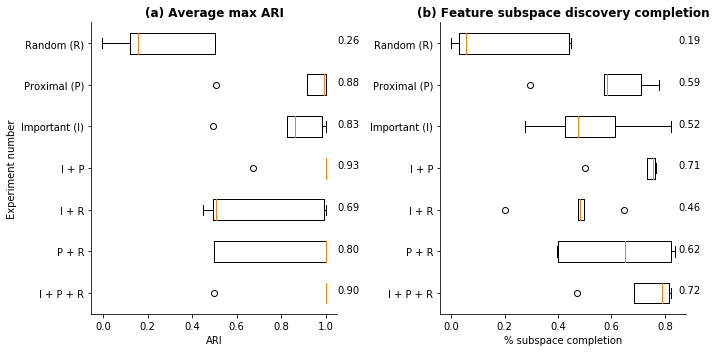

In [9]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
labels = ["I + P + R", "P + R", "I + R", "I + P", "Important (I)",  "Proximal (P)", "Random (R)"]
methods = np.mean(np.array(combined_ari), axis =1).T
plt.boxplot(list(methods), vert=False);
plt.yticks(np.arange(len(methods)) + 1, labels, rotation = 0, );
# plt.ylim(-0.05, 1.1)
for i in range(len(methods)):
    plt.text( 1.05,i+0.99, format(np.mean(methods[i]), '.2f'))
sns.despine()
plt.title("(a) Average max ARI", fontweight = "bold")
plt.ylabel("Experiment number")
plt.xlabel("ARI")

plt.subplot(122)
methods = np.mean(np.array(combined), axis =1).T
plt.boxplot(list(methods), vert=False);
plt.yticks(np.arange(len(methods)) + 1, labels, rotation = 0, );
# plt.ylim(-0.05, 1.1)
for i in range(len(methods)):
    plt.text( 0.85,i+0.99, format(np.mean(methods[i]), '.2f'))
sns.despine()
plt.title("(b) Feature subspace discovery completion", fontweight = "bold")
plt.ylabel("")
plt.xlabel("% subspace completion")
plt.tight_layout()
plt.savefig(f"../images/sampling_importance.pdf", bbox_inches='tight')

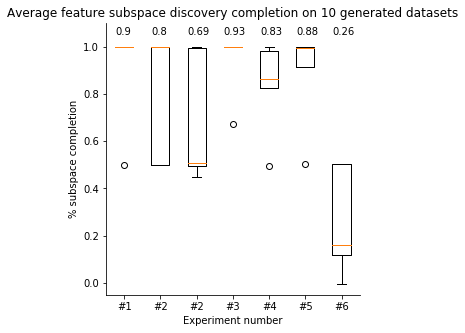

In [33]:

methods = np.mean(np.array(combined_ari), axis =1).T
plt.boxplot(list(methods));
plt.xticks(np.arange(len(methods)) + 1, final_result.columns, rotation = 0);
plt.ylim(-0.05, 1.1)
for i in range(len(methods)):
    plt.text(i+0.75, 1.05, round(np.mean(methods[i]), 2))
sns.despine()
plt.title("Average feature subspace discovery completion on 10 generated datasets")
plt.xlabel("Experiment number")
plt.ylabel("% subspace completion")
plt.savefig(f"../images/sampling_importance.pdf", bbox_inches='tight')

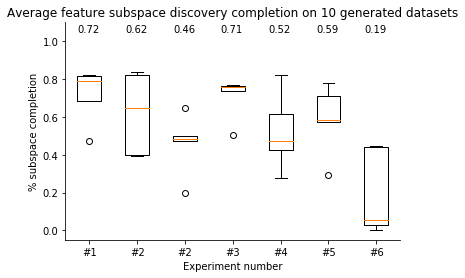

In [22]:
methods = np.mean(np.array(combined), axis =1).T
plt.boxplot(list(methods));
plt.xticks(np.arange(len(methods)) + 1, final_result.columns, rotation = 0);
plt.ylim(-0.05, 1.1)
for i in range(len(methods)):
    plt.text(i+0.75, 1.05, round(np.mean(methods[i]), 2))
sns.despine()
plt.title("Average feature subspace discovery completion on 10 generated datasets")
plt.xlabel("Experiment number")
plt.ylabel("% subspace completion")
plt.savefig(f"../images/sampling_importance.pdf", bbox_inches='tight')

(0.0, 1.2, 0.04, 1.0)

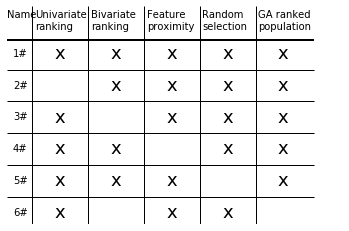

In [12]:
plt.figure(figsize = (6, 4))
# plt.subplot(121)
selected = [[1, 1, 1, 1, 1], [0, 1, 1, 1, 1], [1, 0, 1, 1, 1], [1, 1, 0, 1, 1],
            [1, 1, 1, 0, 1], [1, 0, 1, 1, 0]]

vline_offset = 0.01
column_offsets = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
plt.text(column_offsets[0], 0.9, "Name\n")
plt.text(column_offsets[1], 0.9, "Univariate\nranking")
plt.text(column_offsets[2], 0.9, "Bivariate\nranking")
plt.text(column_offsets[3], 0.9, "Feature\nproximity")
plt.text(column_offsets[4], 0.9, "Random \nselection")
plt.text(column_offsets[5], 0.9, "GA ranked \npopulation")
for i in column_offsets[1:]:
    plt.vlines(x = i - vline_offset, ymin=0, ymax =1, color = "black", linewidth = 1);
plt.hlines(y = 0.85, xmin=0, xmax =1.1, color = "black", linewidth = 2);
plt.xlim(0,1.2)
plt.ylim(0.04,1)

for i in range(len(selected)):
    plt.text(column_offsets[0] + 0.02, 0.78 - i * 0.14, f"{i+1}#")
    plt.hlines(y = 0.78 - (i +1)* 0.14 + 0.08, xmin=0, xmax =1.1, color = "black", linewidth = 1);
    for j in range(len(selected[0])):
        if selected[i][j] ==1:
            plt.text(column_offsets[j+1] + 0.07, 0.77 - i * 0.14, "x", fontsize = 18)
plt.axis("off")

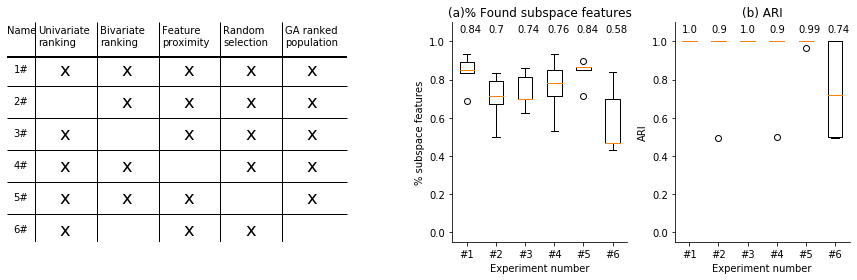

In [22]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
selected = [[1, 1, 1, 1, 1], [0, 1, 1, 1, 1], [1, 0, 1, 1, 1], [1, 1, 0, 1, 1],
            [1, 1, 1, 0, 1], [1, 0, 1, 1, 0]]

vline_offset = 0.01
column_offsets = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
plt.text(column_offsets[0], 0.9, "Name\n")
plt.text(column_offsets[1], 0.9, "Univariate\nranking")
plt.text(column_offsets[2], 0.9, "Bivariate\nranking")
plt.text(column_offsets[3], 0.9, "Feature\nproximity")
plt.text(column_offsets[4], 0.9, "Random \nselection")
plt.text(column_offsets[5], 0.9, "GA ranked \npopulation")
for i in column_offsets[1:]:
    plt.vlines(x = i - vline_offset, ymin=0, ymax =1, color = "black", linewidth = 1);
plt.hlines(y = 0.85, xmin=0, xmax =1.1, color = "black", linewidth = 2);
plt.xlim(0,1.2)
plt.ylim(0.04,1)

for i in range(len(selected)):
    plt.text(column_offsets[0] + 0.02, 0.78 - i * 0.14, f"{i+1}#")
    plt.hlines(y = 0.78 - (i +1)* 0.14 + 0.08, xmin=0, xmax =1.1, color = "black", linewidth = 1);
    for j in range(len(selected[0])):
        if selected[i][j] ==1:
            plt.text(column_offsets[j+1] + 0.07, 0.77 - i * 0.14, "x", fontsize = 18)
plt.axis("off")
plt.tight_layout()




mapping = {
    'all_equal': "Equal",
    'current': "Proposed",
    'no_archive': "No init generations",
    'no_archive_sampling': "No 2D ranking",
    'no_close': "No feature proximity",
    'no_imp': "No 1D ranking",
    'no_random': "No random"
}

mapping = {
    'all_equal': "#1",
    'no_imp': "#2",
    
    'no_archive_sampling': "#3",
    'no_close': "#4",
    
    'no_random': "#5",
#     'current': "#6",
    'no_archive': "#6",
}
plt.subplot(143)
combined=[]
for t in range(5):
    final_result = pd.read_pickle(f"data/sampling_results_{t}.pkl")
    final_result = final_result.groupby(["subspace_id", "experiment"]
                                       ).agg({"identified_features": max}).unstack("experiment")
    final_result.columns = final_result.columns.levels[1].values
#     final_result = final_result[['all_equal',  'no_archive_sampling', 'no_close',
#        'no_imp', 'no_random', 'current', 'no_archive' ]]
    final_result = final_result[['all_equal',  'no_imp','no_archive_sampling', 'no_close',
        'no_random',  'no_archive' ]]
    final_result = final_result.rename(columns = mapping)
    combined.append(final_result.values)


methods = np.mean(np.array(combined), axis =1).T
plt.boxplot(list(methods));
plt.xticks(np.arange(len(methods)) + 1, final_result.columns, rotation = 0);
plt.ylim(-0.05, 1.1)
for i in range(len(methods)):
    plt.text(i+0.75, 1.05, round(np.mean(methods[i]), 2))
sns.despine()
# plt.title("Average feature subspace discovery completion on 10 generated datasets")
plt.xlabel("Experiment number")
plt.ylabel("% subspace features")
plt.title("(a)% Found subspace features")

plt.subplot(144)

combined=[]
for t in range(5):
    final_result = pd.read_pickle(f"data/sampling_results_{t}.pkl")
    final_result = final_result.groupby(["subspace_id", "experiment"]
                                       ).agg({"ari": max}).unstack("experiment")
    final_result.columns = final_result.columns.levels[1].values
#     final_result = final_result[['all_equal',  'no_archive_sampling', 'no_close',
#        'no_imp', 'no_random', 'current', 'no_archive' ]]
    final_result = final_result[['all_equal',  'no_imp','no_archive_sampling', 'no_close',
        'no_random',  'no_archive' ]]
    final_result = final_result.rename(columns = mapping)
    combined.append(final_result.values)


methods = np.mean(np.array(combined), axis =1).T
plt.boxplot(list(methods));
plt.xticks(np.arange(len(methods)) + 1, final_result.columns, rotation = 0);
plt.ylim(-0.05, 1.1)
for i in range(len(methods)):
    plt.text(i+0.75, 1.05, round(np.mean(methods[i]), 2))
sns.despine()
# plt.title("Average feature subspace discovery completion on 10 generated datasets")
plt.xlabel("Experiment number")
plt.ylabel("ARI")
plt.title("(b) ARI")

plt.tight_layout()
plt.savefig(f"images/sampling_importance.pdf", bbox_inches='tight')